In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('db_inflacion_colombia.xlsx')

In [3]:
df.head()

,Fecha,Inflacion,inflación promedio,tasa,tasa promedio,desempleo,desempleo_promedio,ise,ise_promedio,ln_ise_promedio,ln_ise,fx,fx_promedio,ln_fx_promedio
0,1993-01-01,0.2482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,745.52,NaN,NaN
1,1993-02-01,0.2471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,749.08,NaN,NaN
2,1993-03-01,0.2418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,764.38,NaN,NaN
3,1993-04-01,0.2308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,771.79,NaN,NaN
4,1993-05-01,0.2221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779.71,NaN,NaN


In [4]:
df.columns

Index(['Fecha', 'Inflacion', 'inflación promedio', 'tasa', 'tasa promedio',
       'desempleo', 'desempleo_promedio', 'ise', 'ise_promedio',
       'ln_ise_promedio', 'ln_ise', 'fx', 'fx_promedio', 'ln_fx_promedio'],
      dtype='object')

In [5]:
df2 = df[['Fecha',  'inflación promedio',  'tasa promedio',
        'desempleo_promedio', 
       'ln_ise_promedio', 'ln_fx_promedio']].copy().dropna()
df2.head()

,Fecha,inflación promedio,tasa promedio,desempleo_promedio,ln_ise_promedio,ln_fx_promedio
156,2006-01-01,0.050138,0.063308,0.119454,4.169832,7.748236
157,2006-02-01,0.049185,0.062923,0.119313,4.173473,7.744687
158,2006-03-01,0.048308,0.062538,0.117213,4.177111,7.742081
159,2006-04-01,0.047608,0.062154,0.116528,4.182614,7.741432
160,2006-05-01,0.046862,0.061955,0.116411,4.184148,7.743702


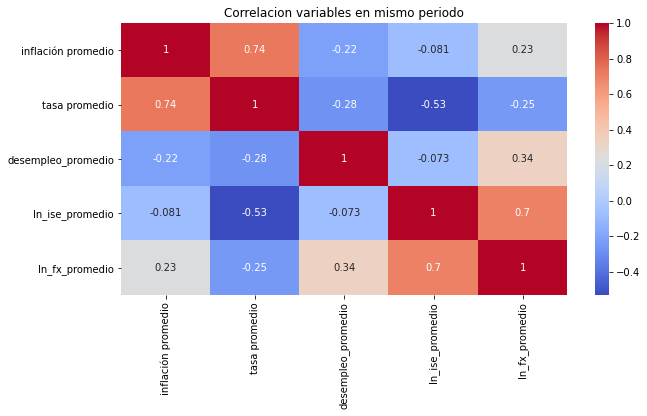

In [6]:
df_correl = df2.corr()
plt.figure(figsize = (10,5))
sns.heatmap(df_correl, annot = True, cmap = 'coolwarm')
plt.title('Correlacion variables en mismo periodo')
plt.show()

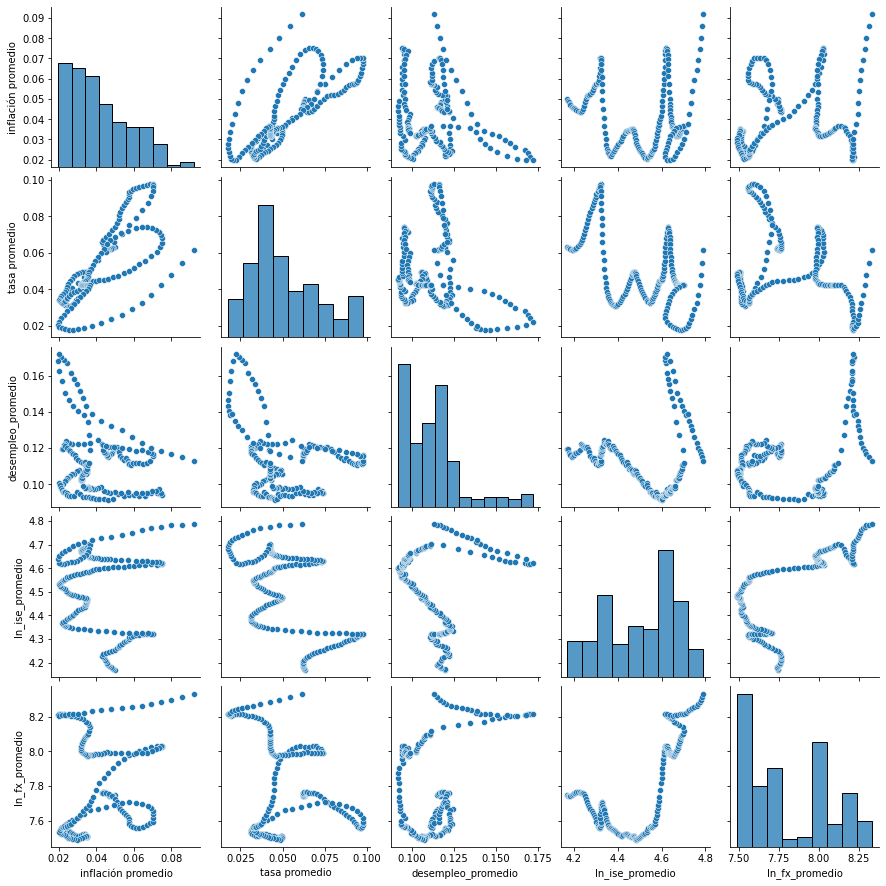

In [7]:
sns.pairplot(df2)
plt.show()

### Causalidad

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

In [9]:
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df2.drop(columns = ['Fecha']), variables =df2.drop(columns = ['Fecha']).columns)

,inflación promedio_x,tasa promedio_x,desempleo_promedio_x,ln_ise_promedio_x,ln_fx_promedio_x
inflación promedio_y,1.0000,0.0000,0.0004,0.0,0.0000
tasa promedio_y,0.0000,1.0000,0.0002,0.0,0.0000
desempleo_promedio_y,0.4155,0.0429,1.0000,0.0,0.0244
ln_ise_promedio_y,0.0217,0.0000,0.0000,1.0,0.0508
ln_fx_promedio_y,0.0152,0.0081,0.0000,0.0,1.0000


Si el p-valor de la celda i,j es < 0.05, entonces x causa y.

* Todas las variables causan inflación promedio
* La inflación causa al ise y a la fx

### Modelo lineal

In [10]:
df2.columns

Index(['Fecha', 'inflación promedio', 'tasa promedio', 'desempleo_promedio',
       'ln_ise_promedio', 'ln_fx_promedio'],
      dtype='object')

In [11]:
Y = df2['inflación promedio']
X = df2[['tasa promedio', 'desempleo_promedio',
       'ln_ise_promedio', 'ln_fx_promedio']]
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing = 'drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     inflación promedio   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     143.0
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           3.02e-57
Time:                        10:04:15   Log-Likelihood:                 686.85
No. Observations:                 203   AIC:                            -1364.
Df Residuals:                     198   BIC:                            -1347.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2139      0.022     -9.668      0.000      -0.258      -0.170
tasa promedio          0.6551      0.044     15.032      0.000       0.569       0.741
desempleo_promedio    -0.1458      0.050     -2.908      0.004      -0.245      -0.047
ln_ise_promedio    -6.126e-05      0.008     -0.008      0.994      -0.016       0.016
ln_fx_promedio         0.0306      0.005      6.753      0.000       0.022       0.039
==============================================================================
Omnibus:                       28.319   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.860
Skew:                           0.871   Prob(JB):                     6.01e-09
Kurtosis:                       4.200   Cond. No.                         948.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VAR

In [21]:
from statsmodels.tsa.api import VAR

# Load data into a pandas DataFrame
data = df2.drop(columns =['Fecha'])

# Fit the VAR model
model = VAR(data)
result = model.fit()

# Get the lag order
lag_order = result.k_ar

# Make predictions
predictions = result.forecast(data.values[-lag_order:], steps=1)

print("Prediction for next period:", predictions[0, :])

Prediction for next period: [0.09609554 0.06534522 0.11185976 4.79100933 8.34937879]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [20]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Feb, 2023
Time:                     10:07:15
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -69.1928
Nobs:                     201.000    HQIC:                  -69.7309
Log likelihood:           5673.68    FPE:                3.61122e-31
AIC:                     -70.0966    Det(Omega_mle):     2.76665e-31
--------------------------------------------------------------------
Results for equation inflación promedio
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.002990         0.001220           -2.452           0.014
L1.inflación promedio         1.975573         0.028361           69.657           0.000
L1.tasa promedi

## impulse response

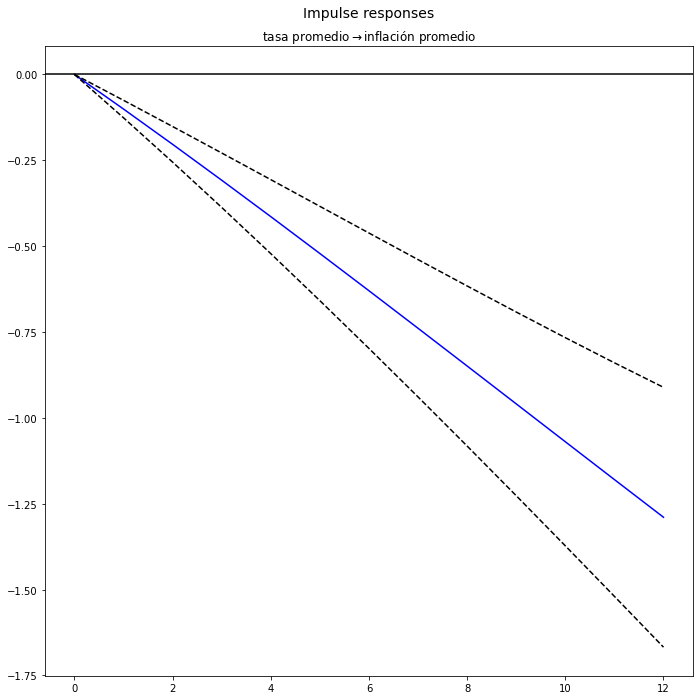

In [38]:
# Obtain the impulse response functions
irfs = result.irf(periods=12)

# Plot the impulse response functions
irfs.plot(impulse=1, response=0)
plt.show()